# News Topic Classification

The project involves a large dataset of news articles collected over several years. These articles cover a wide range of topics such as world events, sports, business, and science/technology. Each article headline is labeled with a number from 0 to 3, indicating its category, as described below. 

| Value | Topic        |
|:------|:-------------|
| 0     | World        |
| 1     | Sports       |
| 2     | Business     |
| 3     | Sci/Tech     |


Our goal is to create a model that, given an unknown article headline, can classify it into one of these 4 topics.

# Exploring Our Data Set
Our dataset consists of only two columns, *text* and *label*, as shown below:

In [1]:
import pandas as pd
df = pd.read_csv('training_data.csv')
df.head(10)

,text,label
0,Wall St. Bears Claw Back Into the Black (Reute...,2
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2
3,Iraq Halts Oil Exports from Main Southern Pipe...,2
4,"Oil prices soar to all-time record, posing new...",2
5,"Stocks End Up, But Near Year Lows (Reuters) Re...",2
6,Money Funds Fell in Latest Week (AP) AP - Asse...,2
7,Fed minutes show dissent over inflation (USATO...,2
8,Safety Net (Forbes.com) Forbes.com - After ear...,2
9,Wall St. Bears Claw Back Into the Black NEW Y...,2


The columns *text* is, as the named suggests, just the headline of the news article, and *label* has it's classification according to the table mentioned before. As it is obvious, we need to process our text into tokens in order to use it in any prediction models. Here is also a simple code to show that our data is evenly distributed between the four labels:

In [2]:
label_percentage = df['label'].value_counts(normalize=True) * 100
print(label_percentage)

2    25.0
3    25.0
1    25.0
0    25.0
Name: label, dtype: float64


# Pre-processing and Tokenizing
We start by pre-processing our data, as described bellow, and also tokenizing it. Here we create the function **process_data()**, wich receives a dataset, as well as a number to indicate which iteration of the processing we are doing. Later in the notebook it will become clear that more processing is needed, but we didn't want to tamper with the initial results, so we created this way of adding new parts to the function, without making use of them.

### Cleaning
We start by using a regex to remove any HTML elements, to clean the text data.

### Lowercase
We then lowercase every word to ensure uniformity and prevent the model from treating words differently based on their capitalization.

### Special Characters / Punctuation
For this particular problem, special characters and punctuation marks don't contribute much to the meaning of the text and can be removed (opinion could be different if this was a sentiment analysis instead of a topic classification problem)

### Tokenization
We then split the text into individual words/tokens, as it helps capture semantic more effectively.

### Stopwords
Stopwords are common words that occur frequently in language, but, in a topic classification problem, carry virtually no useful information. Removing them reduces the noise in the data.

### Stemming
We reduce words to their base or root form, as it reduces the size of vocabulary and the dimensionality of the feature space.

In [3]:
import pandas as pd
import re
import nltk
from nltk import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from collections import Counter
nltk.download('stopwords')
nltk.download('punkt')

stemmer = PorterStemmer()

def stem_tokens(tokens):
    return [stemmer.stem(token) for token in tokens]

lemmatizer = WordNetLemmatizer()

def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

def tokenize_numbers(text):
    year_pattern = r'\b\d{4}\b'
    percentage_pattern = r'\b\d+(?:\.\d+)?%'
    time_pattern = r'\b\d+\s*(?:hours?|mins?|minutes?|secs?|seconds?|days?|weeks?|months?|years?|decades?)\b'
    number_pattern = r'\b\d+\b'
    date_pattern = r'\b\d{1,2}/\d{1,2}/\d{4}\b'

    text = re.sub(percentage_pattern, 'percentagetoken', text)
    text = re.sub(date_pattern, 'datetoken', text)
    text = re.sub(year_pattern, 'yeartoken', text)
    text = re.sub(time_pattern, 'timetoken', text)
    text = re.sub(number_pattern, 'numbertoken', text)

    return text

def remove_rare_words(tokens, threshold=100):
    word_counts = Counter(tokens)
    return [token for token in tokens if word_counts[token] >= threshold]

def process_data(data, mode):
    if(mode >= 2):
        data['text'] = data['text'].apply(tokenize_numbers)

    # Cleaning
    data['text'] = data['text'].str.replace(r'#\d+;', '', regex=True)

    # Lowercase
    data['text'] = data['text'].str.lower()

    # Special Characters / Punctuation
    data['text'] = data['text'].str.replace(r'[^\w\s]', '', regex=True)

    # Tokenization
    data['tokens'] = data['text'].apply(nltk.word_tokenize)

    # Stopwords
    stop_words = set(stopwords.words('english'))
    if(mode >= 2):
        stop_words.update(['ap', 'reuters', 'space.com', 'techweb', 'maccentral', 'pc world', 'usatoday.com', 'cnn'])
        #data['tokens'] = data['tokens'].apply(remove_rare_words)

    data['tokens'] = data['tokens'].apply(lambda x: [word for word in x if word.lower() not in stop_words])

    if(mode == 1 or mode == 2):
        data['tokens'] = data['tokens'].apply(stem_tokens)
    
    if(mode == 3):
        data['tokens'] = data['tokens'].apply(lemmatize_tokens)
        
    return data

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Utilizador\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Utilizador\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Model Training
Now that we can process our data, we can work on training some models. Here we create the function **train_data** to train a few models and compare which yield the best results when classifying the headline topics. We use the the Naive Bayes, the Decision Tree, and the Logistic Regression algorithms.

In [4]:
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from pycaret.classification import *
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

def train_data(training_data, test_data, mode):
    X_train = training_data['text']
    y_train = training_data['label']
    X_val = test_data['text']
    y_val = test_data['label']
    
    vectorizer = CountVectorizer(analyzer='word', max_features=6000, lowercase=True, stop_words='english', ngram_range=(1, 2))
    if(mode == 3):
        vectorizer = TfidfVectorizer(stop_words='english')
    
    X_train = vectorizer.fit_transform(X_train)
    
    X_val = vectorizer.transform(X_val) 
    
    model_nb = MultinomialNB()
    model_dt = DecisionTreeClassifier(random_state=123)
    model_rf = RandomForestClassifier(random_state=123)
    model_lr = LogisticRegression(solver='lbfgs', max_iter=1000)
        
    print('----------------------------------------------------------------')
    model_nb = model_nb.fit(X=X_train, y=y_train)
    y_pred_nb = model_nb.predict(X_val)
    print("Naive Bayes Accuracy:", accuracy_score(y_val, y_pred_nb))
    print("Naive Bayes Confusion Matrix:")
    print(confusion_matrix(y_val, y_pred_nb))
    print("Naive Bayes Classification Report:")
    print(classification_report(y_val, y_pred_nb))
    print()
    
    print('----------------------------------------------------------------')
    model_dt = model_dt.fit(X=X_train, y=y_train)
    y_pred_dt = model_dt.predict(X_val)
    print("Decision Tree Accuracy:", accuracy_score(y_val, y_pred_dt))
    print("Decision Tree Confusion Matrix:")
    print(confusion_matrix(y_val, y_pred_dt))
    print("Decision Tree Classification Report:")
    print(classification_report(y_val, y_pred_dt))
    print()
    
    print('----------------------------------------------------------------')
    model_lr = model_lr.fit(X=X_train, y=y_train)
    y_pred_lr = model_lr.predict(X_val)
    print("Logistic Regression Accuracy:", accuracy_score(y_val, y_pred_lr))
    print("Logistic Regression Confusion Matrix:")
    print(confusion_matrix(y_val, y_pred_lr))
    print("Logistic Regression Classification Report:")
    print(classification_report(y_val, y_pred_lr))
        

In [5]:
training_data = pd.read_csv('training_data.csv')
#training_data = pd.read_csv('training_data_xs.csv')
test_data = pd.read_csv('test_data.csv')

mode = 1

training_data = process_data(training_data, mode)
test_data = process_data(test_data, mode)
train_data(training_data, test_data, mode)

----------------------------------------------------------------
Naive Bayes Accuracy: 0.75
Naive Bayes Confusion Matrix:
[[4 0 1 0]
 [0 5 0 0]
 [1 0 4 0]
 [1 1 1 2]]
Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.80      0.73         5
           1       0.83      1.00      0.91         5
           2       0.67      0.80      0.73         5
           3       1.00      0.40      0.57         5

    accuracy                           0.75        20
   macro avg       0.79      0.75      0.73        20
weighted avg       0.79      0.75      0.73        20


----------------------------------------------------------------
Decision Tree Accuracy: 0.5
Decision Tree Confusion Matrix:
[[2 1 1 1]
 [0 3 0 2]
 [0 0 3 2]
 [0 2 1 2]]
Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.40      0.57         5
           1       0.50      0.60      0.55   

Here we can see that even though our process has been quite unrefined, with little analysis, we already have promising results, specially the 0,75 Accuracy from Naive Bayes and Logistic Regression.

## Iteration 1
So far we rushed a bit into running our models, but let's take a step back and look at how our tokenized data is coming out of our processing function:

In [6]:
import matplotlib.pyplot as plt
from collections import Counter

# Function to get the top 10 most frequent tokens for each group
def get_top_tokens(group):
    all_tokens = [token for sublist in group for token in sublist]
    token_freq = nltk.FreqDist(all_tokens)
    top_tokens = token_freq.most_common(10)
    return top_tokens

# Group the data by label
def print_top_10_from_label(test_data):
    grouped_data = test_data.groupby('label')

    # Dictionary to store top tokens for each label
    top_tokens_dict = {}

    # Get top tokens for each label
    for label, group in grouped_data:
        top_tokens_dict[label] = get_top_tokens(group['tokens'])

    # Plotting
    plt.figure(figsize=(15, 10))

    for i, (label, top_tokens) in enumerate(top_tokens_dict.items(), 1):
        plt.subplot(2, 2, i)
        tokens, frequencies = zip(*top_tokens)
        plt.bar(tokens, frequencies, color='skyblue')
        plt.title(f'Top 10 Tokens for Label: {label}')
        plt.xlabel('Tokens')
        plt.ylabel('Frequency')
        plt.xticks(rotation=45)
        plt.tight_layout()

    plt.show()


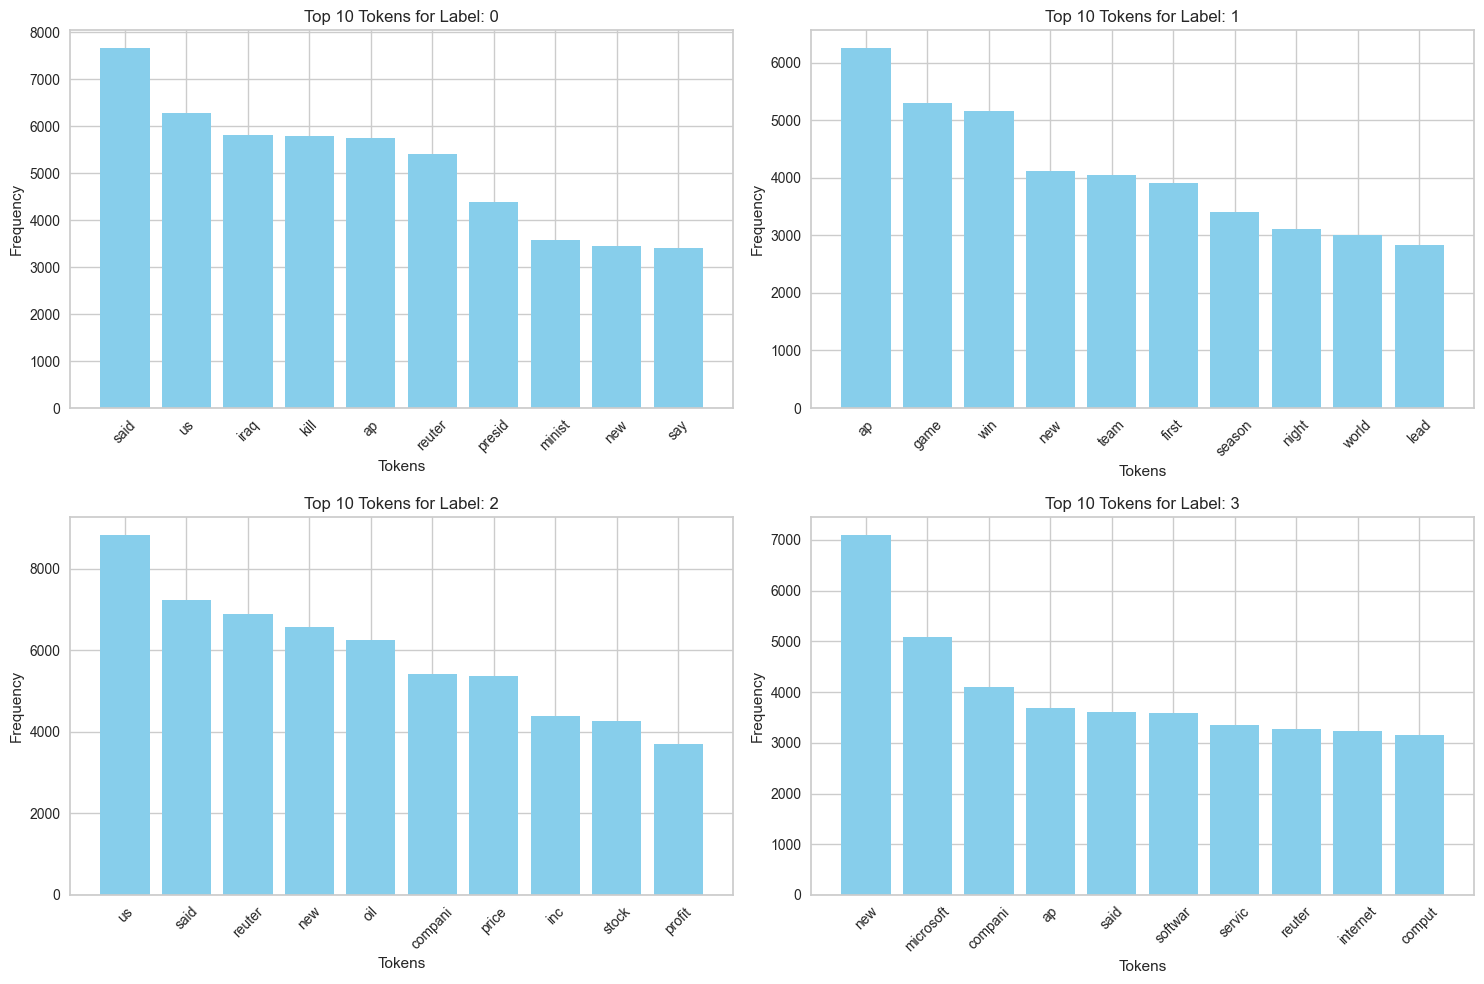

In [7]:
print_top_10_from_label(training_data)

Here we can see 'AP' and 'Reuters' appearing, and after a little checking we can see that that's left-over text telling us which news source the headline was sampled from, which is only increasing noise in our data, so we add that to the stopwords. We also annalysed the data and found a lot of numbers which are being tokenized as simply the number, and so we created a custom function for that.

In [8]:
training_data = pd.read_csv('training_data.csv')
#training_data = pd.read_csv('training_data_xs.csv')
test_data = pd.read_csv('test_data.csv')

mode = 2

training_data = process_data(training_data, mode)
test_data = process_data(test_data, mode)
train_data(training_data, test_data, mode)

----------------------------------------------------------------
Naive Bayes Accuracy: 0.75
Naive Bayes Confusion Matrix:
[[4 0 1 0]
 [0 5 0 0]
 [1 0 4 0]
 [1 1 1 2]]
Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.80      0.73         5
           1       0.83      1.00      0.91         5
           2       0.67      0.80      0.73         5
           3       1.00      0.40      0.57         5

    accuracy                           0.75        20
   macro avg       0.79      0.75      0.73        20
weighted avg       0.79      0.75      0.73        20


----------------------------------------------------------------
Decision Tree Accuracy: 0.45
Decision Tree Confusion Matrix:
[[2 0 1 2]
 [2 2 0 1]
 [0 0 3 2]
 [1 1 1 2]]
Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.40      0.40         5
           1       0.67      0.40      0.50  

## Iteration 2
Here are the same graphs after changes in iteration 1:

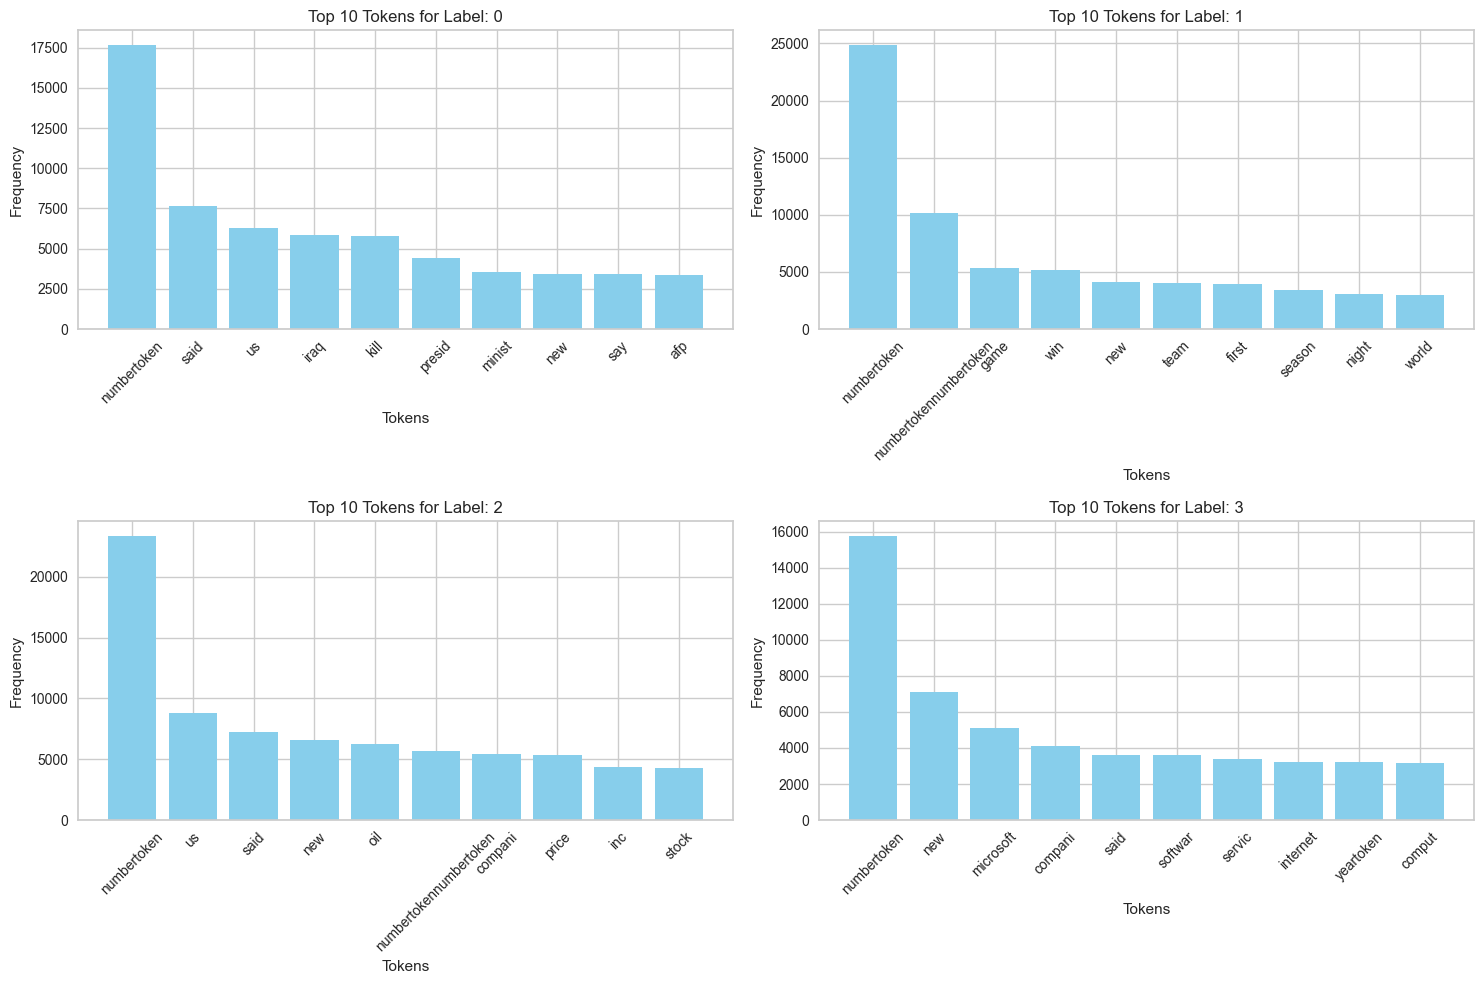

In [9]:
print_top_10_from_label(training_data)

Now that that's looking better, let's try changing stemming for lemmatization.

In [12]:
nltk.download('wordnet')
training_data = pd.read_csv('training_data.csv')
#training_data = pd.read_csv('training_data_xs.csv')
test_data = pd.read_csv('test_data.csv')

mode = 3

training_data = process_data(training_data, mode)
test_data = process_data(test_data, mode)
train_data(training_data, test_data, mode)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Utilizador\AppData\Roaming\nltk_data...


----------------------------------------------------------------
Naive Bayes Accuracy: 0.7
Naive Bayes Confusion Matrix:
[[4 0 1 0]
 [0 4 1 0]
 [1 0 3 1]
 [1 1 0 3]]
Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.80      0.73         5
           1       0.80      0.80      0.80         5
           2       0.60      0.60      0.60         5
           3       0.75      0.60      0.67         5

    accuracy                           0.70        20
   macro avg       0.70      0.70      0.70        20
weighted avg       0.70      0.70      0.70        20


----------------------------------------------------------------
Decision Tree Accuracy: 0.55
Decision Tree Confusion Matrix:
[[2 1 0 2]
 [1 2 0 2]
 [0 0 3 2]
 [0 1 0 4]]
Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.40      0.50         5
           1       0.50      0.40      0.44   

Now we got better results.